Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
=== Conteos por resultado ===
Gol                 : 2
Tiro Atajado        : 2

=== Conteos por característica (origen) ===
de Jugada             : 2
de Corner (centro)    : 1
de Rebote             : 1


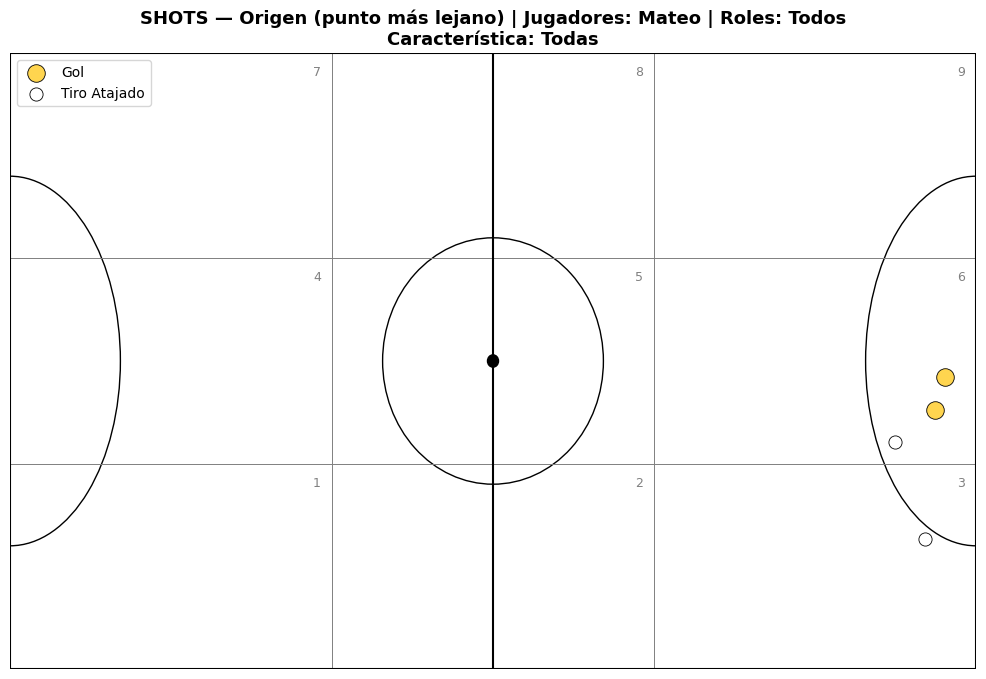

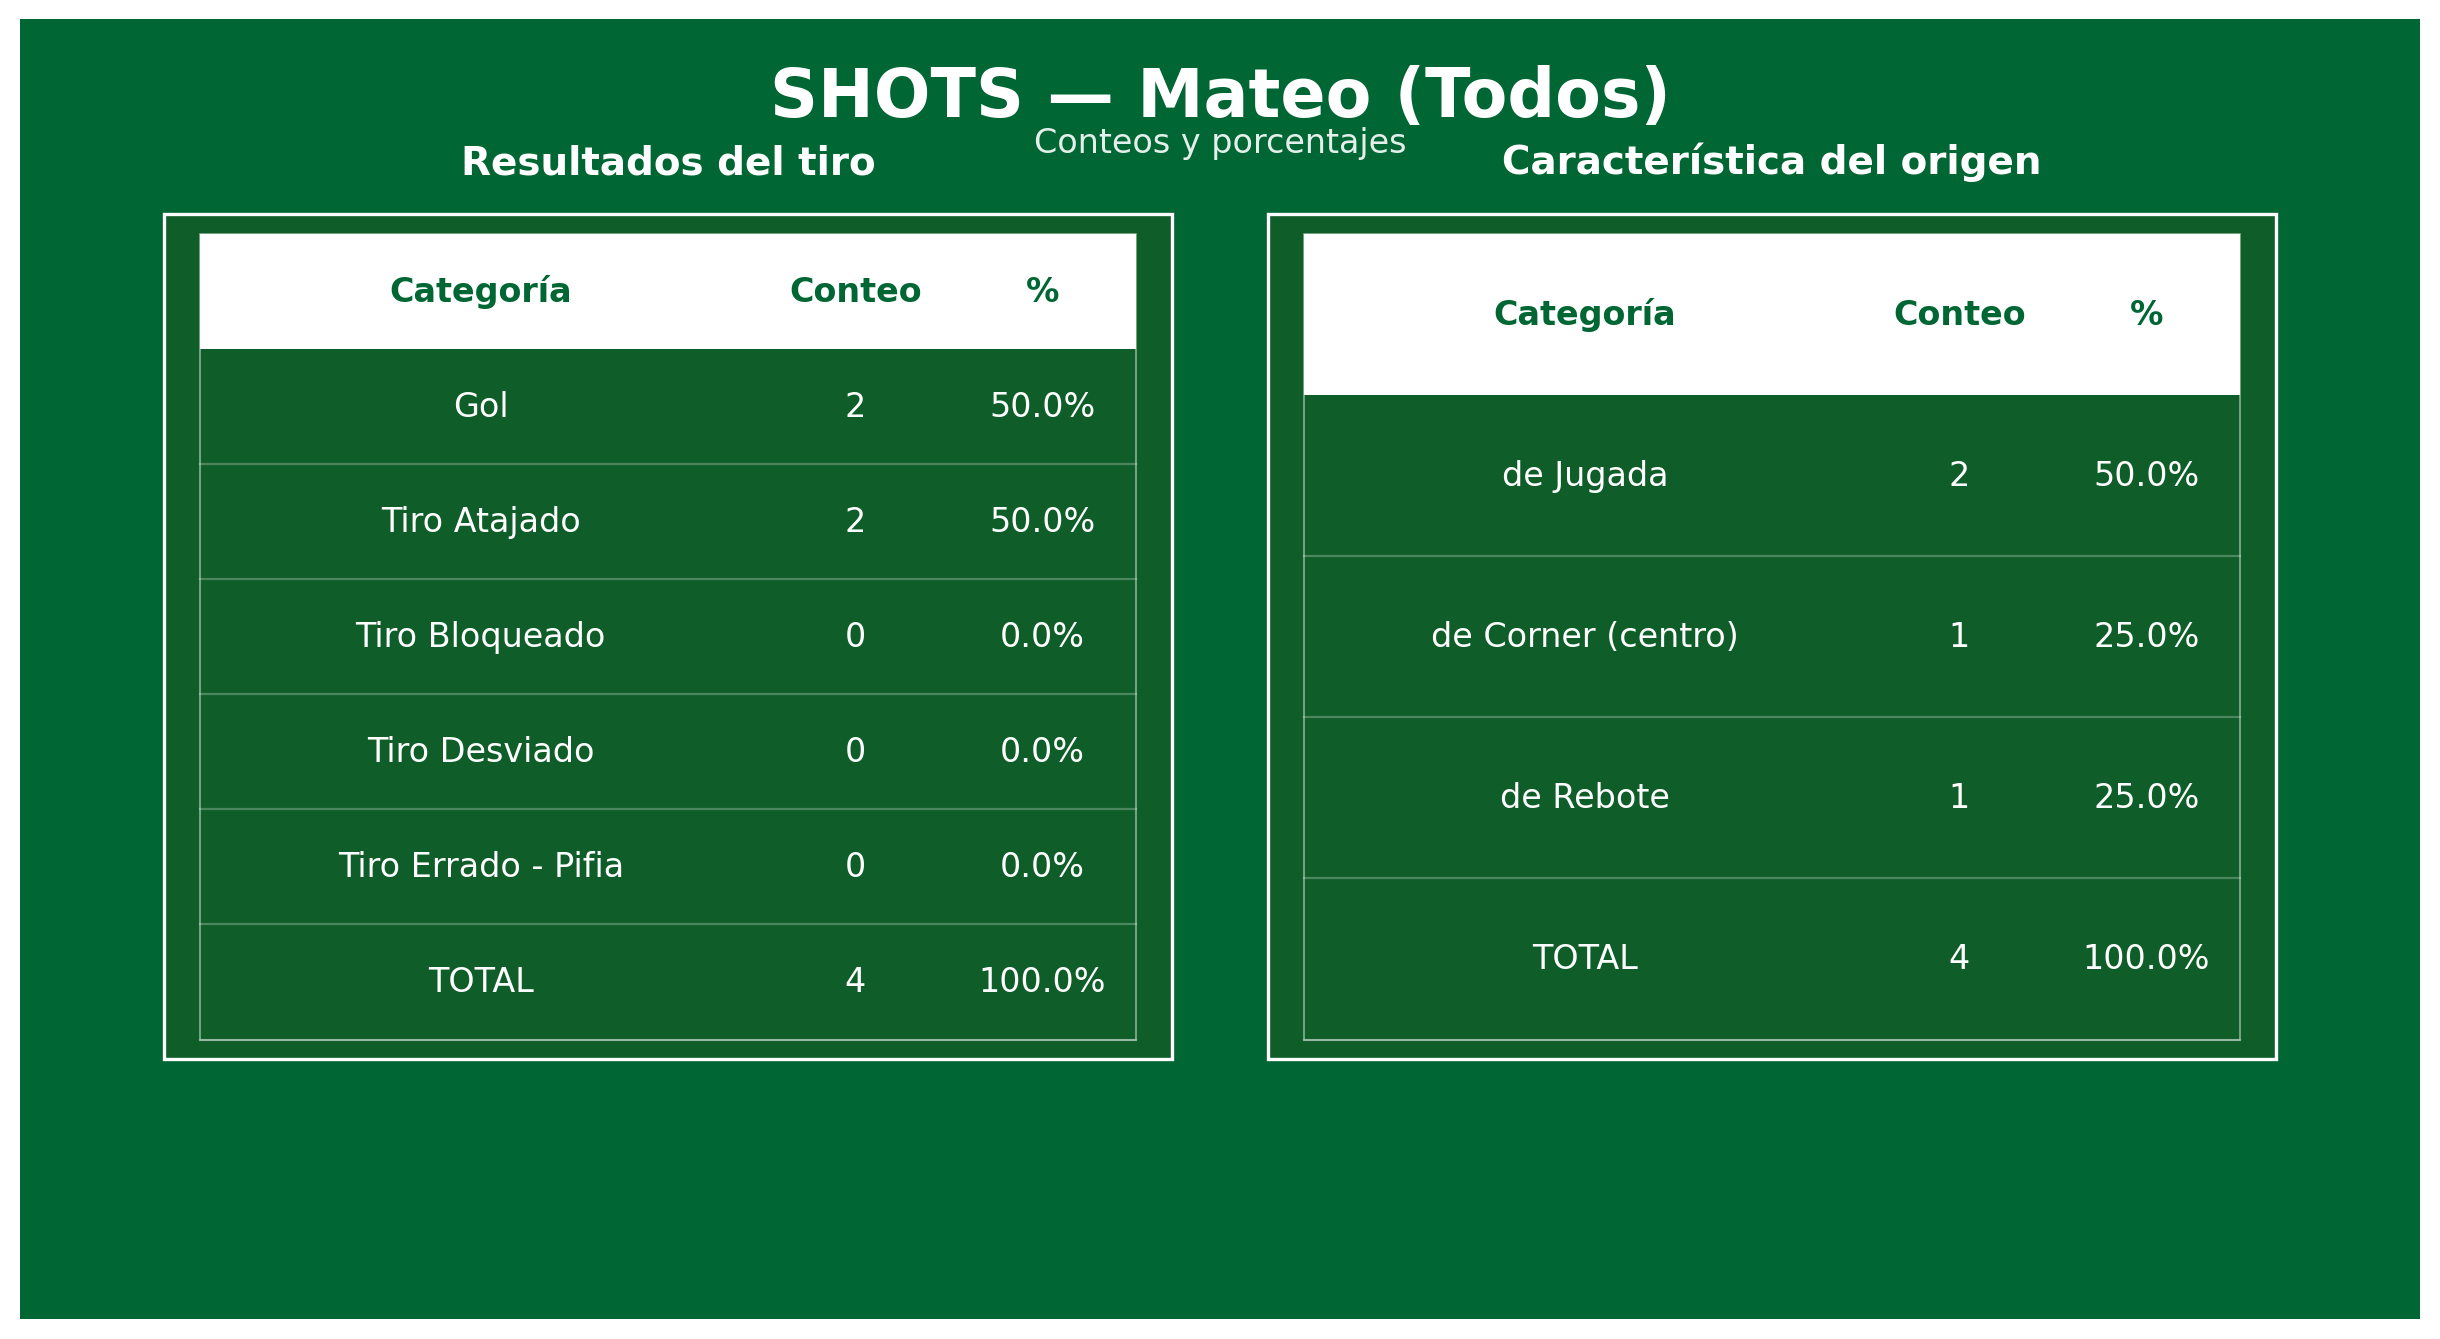

In [20]:
# ============================================================
# SHOTS — Origen (punto más lejano al arco derecho) + TABLAS FERRO
# Filtros: jugador y rol (vacíos = todos)
# Clasificación estricta + filtro por característica del ORIGEN
# Cancha 35x20 con grilla 3x3
# ============================================================

# 0) Montar Drive (Colab)
try:
    from google.colab import drive
    drive.mount('/content/drive')
except Exception:
    pass

# 1) RUTA XML (ajusta si hace falta)
XML_JUGADORES = "/content/drive/MyDrive/Sport Data Campus/TFM/Fecha 8 vs Union/Jugadores/Union Ezpeleta - XML NacSport.xml"

# 2) CANCHA
ANCHO, ALTO = 35.0, 20.0
N_COLS, N_ROWS = 3, 3

# 3) CONFIG de mapeo/visual
FLIP_TO_RIGHT  = True   # invierte en X para que todo apunte a la derecha
FLIP_VERTICAL  = True   # espejo vertical (arriba <-> abajo)
GOAL_PULL      = 0.60   # 0..1 “tirón” hacia el arco (no cambia cuál es el más lejano)

# 4) LOG & SAVE
SHOW_DIAGNOSTIC = True   # muestra ejemplos “Sin clasificar”
SHOW_COUNTS     = True   # imprime conteos en consola
SAVE_SHOT_FIG   = True   # guarda PNG del gráfico de tiros
SAVE_TABLE_FIG  = True   # guarda PNG de las tablas
OUT_DIR         = "/content"

# 5) FILTROS (vacíos = todos)
MIS_JUGADORES = ["Vicente","Brandon","Zurdo","Bruno","JuanBe","Toto","Vito","Fido","Vicen","Pepo","Mateo"]
ROLES_CANON   = ["Ala I","Ala D","Cierre","Pivot","Arq"]

PLAYERS_FILTER = ["Mateo"]        # [] = todos
ROLES_FILTER   = []         # [] = todos
CHAR_FILTER    = []                # [] = todas (p.ej. ["de Tiro Libre"])

# 6) Imports
import os, re, unicodedata, xml.etree.ElementTree as ET
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Arc
from collections import Counter

# ---------- utils ----------
def ntext(s):
    if s is None: return ""
    s = unicodedata.normalize("NFD", str(s))
    s = "".join(ch for ch in s if unicodedata.category(ch) != "Mn")
    return s.strip()

def nlower(s): return ntext(s).lower()

def parse_instances(xml_path):
    root = ET.parse(xml_path).getroot()
    out, all_x, all_y = [], [], []
    for inst in root.findall(".//instance"):
        code   = ntext(inst.findtext("code"))
        labels = [nlower(t.text) for t in inst.findall("./label/text")]
        xs = [int(x.text) for x in inst.findall("./pos_x") if (x.text or "").isdigit()]
        ys = [int(y.text) for y in inst.findall("./pos_y") if (y.text or "").isdigit()]
        if xs and ys: all_x += xs; all_y += ys
        out.append({"code": code, "labels": labels, "xs": xs, "ys": ys})
    max_x = max(all_x) if all_x else 19
    max_y = max(all_y) if all_y else 34
    return out, float(max_x), float(max_y)

def is_shot(ev):
    s = nlower(ev["code"])
    return bool(re.search(r"\b(tiro|remate)\b", s) or any(re.search(r"\b(tiro|remate)\b", l or "") for l in ev["labels"]))

def detect_player(ev):
    hay = [nlower(ev["code"])] + [nlower(l) for l in ev["labels"]]
    for name in MIS_JUGADORES:
        if nlower(name) in " ".join(hay): return name
    return None

def detect_role(ev):
    hay = nlower(ev["code"]) + " " + " ".join(ev["labels"])
    for r in ROLES_CANON:
        if nlower(r) in hay: return r
    return None

# ------ Resultado (estricto) ------
KEYS = {
    "gol":        re.compile(r"\bgol\b"),
    "ataj":       re.compile(r"\bataj"),
    "al_arco":    re.compile(r"\btiro\s*al\s*arco\b"),
    "bloqueado":  re.compile(r"\bbloquead"),
    "desviado":   re.compile(r"\bdesviad"),
    "errado":     re.compile(r"\berrad"),
    "pifia":      re.compile(r"\bpifi"),
}
def has(ev, key):
    patt = KEYS[key]
    if patt.search(nlower(ev["code"])): return True
    return any(patt.search(l or "") for l in ev["labels"])

def shot_result_strict(ev):
    if has(ev, "gol"):                         return "Gol"
    if has(ev, "ataj") or has(ev, "al_arco"):  return "Tiro Atajado"
    if has(ev, "bloqueado"):                   return "Tiro Bloqueado"
    if has(ev, "desviado"):                    return "Tiro Desviado"
    if has(ev, "errado") or has(ev, "pifia"):  return "Tiro Errado - Pifia"
    return "Sin clasificar"

# ------ Característica del ORIGEN ------
CHAR_PATTS = [
    ("de Corner (desde Banda)", re.compile(r"corner\s*\(desde\s*banda\)")),
    ("de Corner (centro)",      re.compile(r"corner\s*\(centro\)")),
    ("de Jugada (centro)",      re.compile(r"jugada\s*\(centro\)")),
    ("de Tiro Libre",           re.compile(r"tiro\s*libre")),
    ("de Rebote",               re.compile(r"\brebote\b")),
    ("de Lateral",              re.compile(r"\blateral\b")),
    ("de Jugada",               re.compile(r"\bde\s*jugada\b")),
]
def shot_characteristic(ev):
    s = nlower(ev["code"]) + " " + " ".join(ev["labels"])
    for name, patt in CHAR_PATTS:
        if patt.search(s): return name
    return "de Jugada"

# ---------- mapeo a cancha (y→x, x→y) + espejos + tirón + clip ----------
def map_raw_to_pitch(x_raw, y_raw, max_x, max_y, flip=True, pull=0.0, flip_v=False):
    x = (y_raw / max_y) * ANCHO
    y = (x_raw / max_x) * ALTO
    if flip:
        x = ANCHO - x
    if flip_v:
        y = ALTO - y
    if pull and 0.0 < pull < 1.0:
        x = x + pull * (ANCHO - x)
    x = float(np.clip(x, 0.0, ANCHO))
    y = float(np.clip(y, 0.0, ALTO))
    return x, y

# ---------- cancha 3×3 ----------
def draw_futsal_pitch_grid(ax):
    dx, dy = ANCHO / N_COLS, ALTO / N_ROWS
    ax.set_facecolor("white")
    ax.plot([0, ANCHO], [0, 0], color="black")
    ax.plot([0, ANCHO], [ALTO, ALTO], color="black")
    ax.plot([0, 0], [0, ALTO], color="black")
    ax.plot([ANCHO, ANCHO], [0, ALTO], color="black")
    ax.plot([ANCHO/2, ANCHO/2], [0, ALTO], color="black")
    ax.add_patch(Arc((0, ALTO/2), 8, 12, angle=0, theta1=270, theta2=90, color="black"))
    ax.add_patch(Arc((ANCHO, ALTO/2), 8, 12, angle=0, theta1=90, theta2=270, color="black"))
    ax.add_patch(plt.Circle((ANCHO/2, ALTO/2), 4, color="black", fill=False))
    ax.add_patch(plt.Circle((ANCHO/2, ALTO/2), 0.2, color="black"))
    for j in range(N_ROWS):
        for i in range(N_COLS):
            x0, y0 = i * dx, j * dy
            ax.add_patch(Rectangle((x0, y0), dx, dy, linewidth=0.6, edgecolor='gray', facecolor='none'))
            zona = j * N_COLS + i + 1
            ax.text(x0 + dx - 0.4, y0 + dy - 0.4, str(zona), ha='right', va='top', fontsize=9, color='gray')
    ax.set_xlim(0, ANCHO); ax.set_ylim(0, ALTO); ax.axis('off')

# ---------- helpers: conteos y tablas “Ferro” ----------
def counts_from_shots(shots):
    want_order = ["Gol","Tiro Atajado","Tiro Bloqueado","Tiro Desviado","Tiro Errado - Pifia"]
    c_res = Counter(s["result"] for s in shots if s["result"] != "Sin clasificar")
    results_counts = {k: c_res.get(k, 0) for k in want_order}

    c_char = Counter(s["char"] for s in shots)
    char_counts = dict(sorted(c_char.items(), key=lambda kv: (-kv[1], kv[0])))
    return results_counts, char_counts

def ferro_tables(results_counts, char_counts, title_main, subtitle, out_path=None):
    # theme
    bg_green = "#006633"; white = "#FFFFFF"; light_green = "#0F5E29"

    # rows builder
    def mk_rows(d):
        tot = sum(d.values())
        rows = [[k, v, f"{(v/tot*100) if tot else 0.0:.1f}%"] for k,v in d.items()]
        rows.append(["TOTAL", tot, "100.0%" if tot else "0.0%"])
        return rows

    rows_results = mk_rows(results_counts)
    rows_char    = mk_rows(char_counts)

    # draw
    plt.close("all")
    fig = plt.figure(figsize=(12, 6.5), dpi=200)
    ax  = fig.add_axes([0,0,1,1]); ax.set_xlim(0,1); ax.set_ylim(0,1); ax.axis("off")
    ax.add_patch(Rectangle((0,0),1,1,facecolor=bg_green, edgecolor="none"))

    ax.text(0.5, 0.94, title_main, ha="center", va="center", color=white, fontsize=24, weight="bold")
    ax.text(0.5, 0.905, subtitle,   ha="center", va="center", color=white, fontsize=12, alpha=0.9)

    card_margin_x = 0.06; card_gap = 0.04
    card_w = (1 - 2*card_margin_x - card_gap) / 2
    card_h = 0.65; card_y = 0.2
    # cards
    ax.add_patch(Rectangle((card_margin_x, card_y), card_w, card_h, facecolor=light_green, edgecolor=white, lw=1.2))
    ax.text(card_margin_x + card_w/2, card_y + card_h + 0.025, "Resultados del tiro", ha="center", va="bottom", color=white, fontsize=14, weight="bold")
    x2 = card_margin_x + card_w + card_gap
    ax.add_patch(Rectangle((x2, card_y), card_w, card_h, facecolor=light_green, edgecolor=white, lw=1.2))
    ax.text(x2 + card_w/2, card_y + card_h + 0.025, "Característica del origen", ha="center", va="bottom", color=white, fontsize=14, weight="bold")

    def draw_table(ax, x0, y0, w, h, rows, headers):
        nrows = len(rows) + 1; row_h = h / nrows
        col_ws = [0.6, 0.2, 0.2]
        # header
        ax.add_patch(Rectangle((x0, y0 + h - row_h), w, row_h, facecolor=white, edgecolor=white, lw=0))
        for j, head in enumerate(headers):
            cx = x0 + sum(col_ws[:j])*w + col_ws[j]*w/2
            ax.text(cx, y0 + h - row_h/2, head, ha="center", va="center", color=bg_green, fontsize=12, weight="bold")
        # rows
        y = y0 + h - row_h
        for i, row in enumerate(rows):
            y -= row_h
            ax.add_line(plt.Line2D([x0, x0+w], [y, y], color=white, alpha=0.25, lw=0.8))
            for j, cell in enumerate(row):
                cx = x0 + sum(col_ws[:j])*w + col_ws[j]*w/2
                ax.text(cx, y + row_h/2, str(cell), ha="center", va="center", color=white, fontsize=12)
        ax.add_patch(Rectangle((x0, y0), w, h, facecolor="none", edgecolor=white, lw=0.6, alpha=0.5))

    draw_table(ax, card_margin_x + 0.015, card_y + 0.015, card_w - 0.03, card_h - 0.03, rows_results, ["Categoría","Conteo","%"])
    draw_table(ax, x2 + 0.015,            card_y + 0.015, card_w - 0.03, card_h - 0.03, rows_char,    ["Categoría","Conteo","%"])

    if out_path and SAVE_TABLE_FIG:
        fig.savefig(out_path, dpi=200, bbox_inches="tight", pad_inches=0.1)
    plt.show()

# ---------- pipeline ----------
def collect_shot_origins(xml_path, char_filter=()):
    evs, max_x, max_y = parse_instances(xml_path)
    rows, raw_unclassified = [], []
    for ev in evs:
        if not is_shot(ev):
            continue
        player = detect_player(ev)
        if not player:  # solo mis jugadores
            continue
        role = detect_role(ev)  # puede ser None
        # filtros
        if PLAYERS_FILTER and (player not in PLAYERS_FILTER): continue
        if ROLES_FILTER   and (role   not in ROLES_FILTER):   continue
        if not (ev["xs"] and ev["ys"]): continue

        coords = [map_raw_to_pitch(xr, yr, max_x, max_y,
                                   flip=FLIP_TO_RIGHT, pull=GOAL_PULL, flip_v=FLIP_VERTICAL)
                  for xr, yr in zip(ev["xs"], ev["ys"])]

        # origen = más lejano al arco derecho (menor X)
        origin = coords[0] if len(coords)==1 else coords[int(np.argmin([c[0] for c in coords]))]

        res = shot_result_strict(ev)
        ch  = shot_characteristic(ev)

        if res == "Sin clasificar":
            raw_unclassified.append({"code": ev["code"], "labels": ev["labels"]})

        if CHAR_FILTER and (ch not in CHAR_FILTER):
            continue

        rows.append({"x": origin[0], "y": origin[1], "result": res, "char": ch,
                     "player": player, "role": role})
    return rows, raw_unclassified

def plot_shot_origins(xml_path, save=True):
    shots, raw_uncls = collect_shot_origins(xml_path, CHAR_FILTER)

    # ----- Conteos (y opcional print) -----
    order = ["Gol","Tiro Atajado","Tiro Bloqueado","Tiro Desviado","Tiro Errado - Pifia","Sin clasificar"]
    cnt = Counter(s["result"] for s in shots)
    if SHOW_COUNTS:
        print("=== Conteos por resultado ===")
        for k in order:
            if cnt.get(k,0): print(f"{k:20s}: {cnt[k]}")
        if not CHAR_FILTER:
            cchar = Counter(s["char"] for s in shots)
            print("\n=== Conteos por característica (origen) ===")
            for k,v in cchar.most_common(): print(f"{k:22s}: {v}")
        if raw_uncls and SHOW_DIAGNOSTIC:
            print("\n⚠️  'Sin clasificar' (muestras):")
            for e in raw_uncls[:15]:
                print(" code:", e["code"], " | labels:", e["labels"])
            if len(raw_uncls) > 15:
                print(f"... (+{len(raw_uncls)-15} más)")

    # ----- Gráfico de puntos -----
    COLORS = {
        "Gol":                "#FFD54F",
        "Tiro Atajado":       "#FFFFFF",
        "Tiro Bloqueado":     "#FF5252",
        "Tiro Desviado":      "#FF7043",
        "Tiro Errado - Pifia":"#6B6F76",
        "Sin clasificar":     "#BDBDBD",
    }

    plt.close("all")
    fig = plt.figure(figsize=(10.5, 7))
    ax  = fig.add_axes([0.04, 0.06, 0.92, 0.88])
    draw_futsal_pitch_grid(ax)

    for res in order:
        pts = [(s["x"], s["y"]) for s in shots if s["result"] == res]
        if not pts: continue
        xs, ys = zip(*pts)
        if res == "Gol":
            ax.scatter(xs, ys, s=160, c=COLORS[res], edgecolors="black", linewidths=0.6, zorder=5, label=res)
        elif res == "Tiro Atajado":
            ax.scatter(xs, ys, s=90,  c=COLORS[res], edgecolors="black", linewidths=0.6, zorder=4, label=res)
        elif res == "Tiro Bloqueado":
            ax.scatter(xs, ys, s=100, facecolors="none", edgecolors=COLORS[res], linewidths=1.8, zorder=4, label=res)
        elif res == "Tiro Desviado":
            ax.scatter(xs, ys, s=90,  facecolors="none", edgecolors=COLORS[res], linewidths=1.6, zorder=3, label=res)
        elif res == "Tiro Errado - Pifia":
            ax.scatter(xs, ys, s=110, marker='x', c=COLORS[res], linewidths=1.8, zorder=3, label=res)
        elif res == "Sin clasificar":
            ax.scatter(xs, ys, s=70,  c=COLORS[res], edgecolors="black", linewidths=0.4, zorder=2, label=res)

    sel_players = ", ".join(PLAYERS_FILTER) if PLAYERS_FILTER else "Todos"
    sel_roles   = ", ".join(ROLES_FILTER)   if ROLES_FILTER   else "Todos"
    sel_char    = "Todas" if not CHAR_FILTER else ", ".join(CHAR_FILTER)
    ax.set_title(
        f"SHOTS — Origen (punto más lejano) | Jugadores: {sel_players} | Roles: {sel_roles}\n"
        f"Característica: {sel_char}",
        fontsize=13, pad=6, weight="bold"
    )
    ax.legend(loc="upper left", frameon=True)

    if save and SAVE_SHOT_FIG:
        import re
        tagP = "ALL" if not PLAYERS_FILTER else re.sub(r"[^A-Za-z0-9]+","_","_".join(PLAYERS_FILTER))
        tagR = "ALL" if not ROLES_FILTER   else re.sub(r"[^A-Za-z0-9]+","_","_".join(ROLES_FILTER))
        tagC = "ALL" if not CHAR_FILTER    else re.sub(r"[^A-Za-z0-9]+","_","_".join(CHAR_FILTER))
        out  = f"{OUT_DIR}/shots_origen_jug-{tagP}_rol-{tagR}_char-{tagC}.png"
        fig.savefig(out, dpi=300, bbox_inches="tight", pad_inches=0.05)
    plt.show()

    # ----- TABLA FERRO (con los mismos conteos) -----
    results_counts, char_counts = counts_from_shots(shots)
    title_main = f"SHOTS — {sel_players if sel_players!='Todos' else 'Equipo completo'} ({sel_roles})"
    subtitle   = "Conteos y porcentajes"
    import re
    tagP = "ALL" if not PLAYERS_FILTER else re.sub(r"[^A-Za-z0-9]+","_","_".join(PLAYERS_FILTER))
    tagR = "ALL" if not ROLES_FILTER   else re.sub(r"[^A-Za-z0-9]+","_","_".join(ROLES_FILTER))
    out_table = f"{OUT_DIR}/tabla_shots_ferro_jug-{tagP}_rol-{tagR}.png"
    ferro_tables(results_counts, char_counts, title_main, subtitle, out_path=out_table)

# 7) Ejecutar
if not os.path.exists(XML_JUGADORES):
    raise FileNotFoundError(f"No se encontró: {XML_JUGADORES}")

plot_shot_origins(XML_JUGADORES)
